In [1]:
# PROJ518 - Cotton Disease Identification
# Goel Biju (10576090)

# Baseline Models - Testing

import tensorflow as tf
print("TensorFlow version: " + tf.__version__)

# Find GPU device
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import Precision, Recall, BinaryAccuracy

import numpy as np

import cv2
from matplotlib import pyplot as plt

import os
import shutil

import itertools

from sklearn.metrics import confusion_matrix

# Fix random seed for reproducibility
np.random.seed(42)

TensorFlow version: 2.8.2
Found GPU at: /device:GPU:0
1 Physical GPUs, 1 Logical GPUs


In [2]:
from google.colab import drive

# Importing the dataset (stored in Google Drive)
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
data_dir = "/content/drive/MyDrive/PROJ518/Cotton Dataset/data"

epochs = 50 # 10, 25, 50, 100
batch_size = 32 # 32, 64, 128

In [4]:
test_data = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, 'test'),
    image_size=(256, 256),
    batch_size=batch_size,
    label_mode="binary",
    seed=42)

print(test_data.class_names)

Found 191 files belonging to 2 classes.
['healthy', 'leaf_curl']


In [5]:
# Normalise the images
normalisation_layer = tf.keras.layers.Rescaling(1./255)

test_data = test_data.map(lambda x, y: (normalisation_layer(x), y))

In [6]:
# Load and test the saved model
test_model = load_model("/content/drive/MyDrive/PROJ518/models/baseline/proj518_baseline_2-e50-bs32-da-false-combined")

test_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 192)     14592     
                                                                 
 zero_padding2d (ZeroPadding  (None, 256, 256, 192)    0         
 2D)                                                             
                                                                 
 dense (Dense)               (None, 256, 256, 160)     30880     
                                                                 
 dense_1 (Dense)             (None, 256, 256, 96)      15456     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 96)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 96)      0

In [7]:
test_imgs, test_labels = next(iter(test_data))
print(test_labels)

tf.Tensor(
[[1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]], shape=(32, 1), dtype=float32)


In [8]:
y_pred = test_model.predict(x=test_data, verbose=2)

6/6 - 14s - 14s/epoch - 2s/step


In [9]:
np.round(y_pred)

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],

In [10]:
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
# and Made with ML's introductory notebook - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
import itertools
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
             horizontalalignment="center",
             color="white" if cm[i, j] > threshold else "black",
             size=text_size)

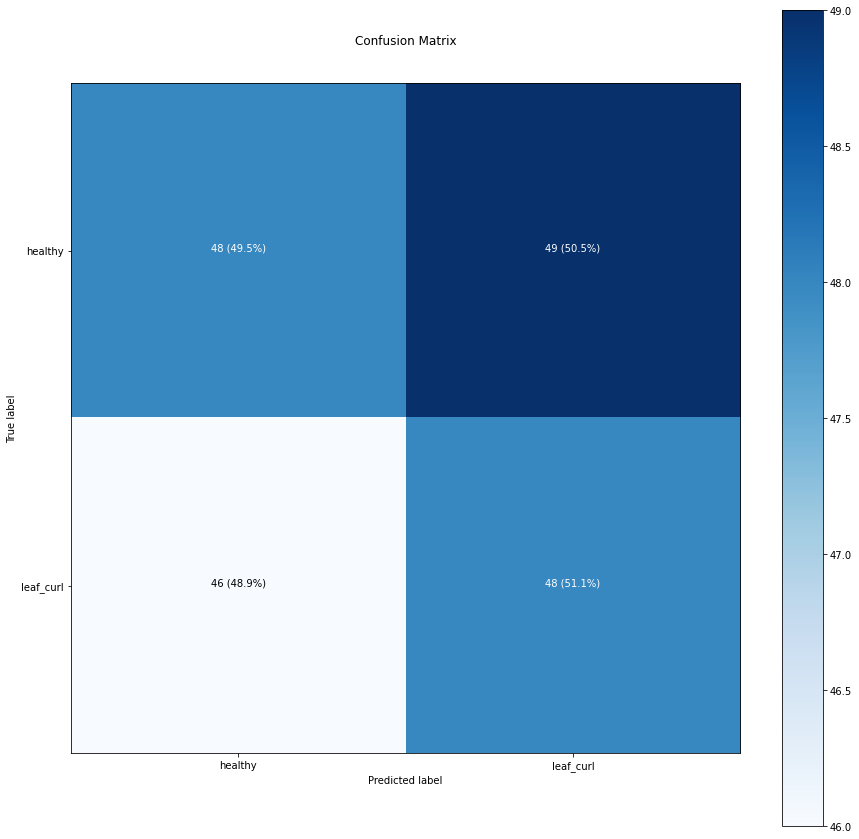

In [11]:
# print(y_test[:10])
# print(tf.round(y_pred)[:10])

y_test = tf.concat([y for x, y in test_data], axis=0)

# confusion_matrix(y_test, tf.round(y_pred))
make_confusion_matrix(y_true=y_test, 
                      y_pred=tf.round(y_pred),
                      classes=['healthy', 'leaf_curl'],
                      figsize=(15, 15),
                      text_size=10)

In [ ]:
# # Prediction on test dataset
# test_dir = "/content/drive/MyDrive/PROJ518/Cotton Dataset/data/"

# # IMG_20210929_131745_393.jpg (healthy)
# # IMG_20211008_134111_814.jpg, IMG_20211008_134152_686 (leaf curl)
# image_path = os.path.join(test_dir, 'leaf_curl', 'IMG_20211004_160551_293.jpg')
# print(image_path)

# img = cv2.imread(image_path)
# img.shape
# # plt.imshow(img)
# plt.show()

# resize = tf.image.resize(img, (256, 256))
# plt.imshow(resize.numpy().astype(int))
# plt.show()

# yhat = model.predict(np.expand_dims(resize/255, 0))
# print(yhat)

# if yhat > 0.5: 
#     print(f'Predicted class is leaf curl virus')
# else:
#     print(f'Predicted class is healthy leaf')